 # Diffusion Demo <img src="http://localhost:8888/LOGO-GliMR.png" align="right" height="100" width="100" >


### Loading data

Let's start by loading some dMRI data using Dipy [dipy.org](https://dipy.org/) This dataset was kindly provided by Hansen and Jespersen [Hansen2016](https://www.nature.com/articles/sdata201672).

In [1]:
import dipy
from dipy.data import get_fnames
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

The downloaded data contains four files: 1) a NIFTI file containing dMRI data; 2) b-values list; 3) diffusion gradient directions (b-vectors); 4) T1-weighted structural NIFTI image.

Below we print their paths:

In [2]:
print(fraw)
print(fbval)
print(fbvec)
print(t1_fname)

/home/rgnunes/.dipy/cfin_multib/__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.nii
/home/rgnunes/.dipy/cfin_multib/__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.bval
/home/rgnunes/.dipy/cfin_multib/__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.bvec
/home/rgnunes/.dipy/cfin_multib/T1.nii


**Note:** Like many other tools, Dipy handles dMRI data in the NIFTI format. If your data is in DICOM format, you need to convert them to NIFTI using for example [dicom2nifti](https://pypi.org/project/dicom2nifti/)

### Reading data

1) To read the dMRI data we use Dipy's function "load_nifti"

In [3]:
from dipy.io.image import load_nifti

data, affine = load_nifti(fraw)

2) To read the b-values and b-vectors we use Dipy's function "read_bvals_bvecs"

In [4]:
from dipy.io.gradients import read_bvals_bvecs

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

To have a sense of the raw dMRI images let's inspect the data:

In [5]:
print("The shape of variable data is {}".format(data.shape))

The shape of variable data is (96, 96, 19, 496)


dMRI data typically corresponds to a 4D matrix: three dimensions correspond to the voxel coordinates while the last coordinate corresponds to the number of diffusion-weighted volumes (496 in this case). 

Let's visualize the middle axial slice of the 158th dMRI volume.

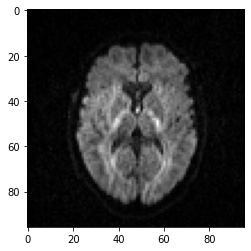

In [6]:
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

mid_sli = 9
exp_ind = 157
# Python indexing starts from 0 so the 158th experiment corresponds to index 157

# rotating the image 
plt.imshow(rotate(data[:, :, mid_sli, exp_ind], angle=90), cmap='gray')

The variable bvals contains the b-values of each dMRI volume and thus its length corresponds to the the last dimension of the dMRI data.

In [7]:
print("The shape of variable bvals is {}".format(bvals.shape))

The shape of variable bvals is (496,)


Regarding the variable bvecs, this is a 496 $\times$ 3 matrix corresponding to the 3 coordinates of the gradient directions of all 496 experiments: 

In [8]:
print("The shape of variable bvecs is {}".format(bvecs.shape))

The shape of variable bvecs is (496, 3)


Below we print the b-value and diffusion gradient direction used for the 158th dMRI experiment

In [9]:
print("158th experiment was acquired with b-value={} s/mm^2".format(bvals[exp_ind]))
print("158th experiment was acquired with b-vector={}".format(bvecs[exp_ind, :]))

158th experiment was acquired with b-value=1000.0 s/mm^2
158th experiment was acquired with b-vector=[ 0.999054  -0.037643  -0.0217622]


### Creating the GradientTable Object

In DIPY, an object called "GradientTable" is used to summarize the diffusion acquisition parameters (b-values, b-vectors, and others if specified).

In [10]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

The "gtab" object can be useful to quickly inspect information about the acquisition parameters. For example, the object attribute "b0s_mask" retrieves a boolean array in which elements with True value indicates the experiments acquired by b-value=0.

In [11]:
print(gtab.b0s_mask)

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

The b-values and b-vectors are also stored in the attributes gtab.bvals and gtab.bvecs respectively.

Below we print again the b-value and b-vector of the 158th volume using the "gtab" attributes

In [12]:
print("158th volume was acquired with b-value={} s/mm^2".format(gtab.bvals[exp_ind]))
print("158th volume was acquired with b-vector={}".format(gtab.bvecs[exp_ind, :]))

158th volume was acquired with b-value=1000.0 s/mm^2
158th volume was acquired with b-vector=[ 0.999054  -0.037643  -0.0217622]


Now that we are familiarized with the dMRI data format, we can for example:

1) Use gtab.b0s_mask to select the dMRI data acquired with b-value=0.

2) Plot the middle slice of the selected data, together with the middle slices of the data acquired of experiments 154, 158, 484, 488.

3) Print the b-values and b-vectors of experiments 154, 158, 484, 488.


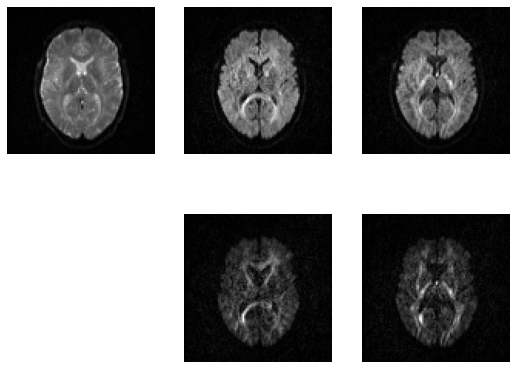

b-value = [1000. 1000. 3000. 3000.] s/mm^2
b-vectors = [[ 0.443994  -0.111793   0.889028 ]
 [ 0.999054  -0.037643  -0.0217622]
 [ 0.443656  -0.109618   0.889468 ]
 [ 0.999069  -0.0357358 -0.0241859]] 


In [13]:
import numpy as np

# Select data acquired with b-value = 0
S0 = np.mean(data[..., gtab.b0s_mask], axis=-1)

# Plot middle slice data
plt.figure(figsize=(9, 7))

plt.subplot(2, 3, 1).set_axis_off()
plt.imshow(np.rot90(S0[..., mid_sli]), cmap='gray')

plt.subplot(2, 3, 2).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 153]), cmap='gray')

plt.subplot(2, 3, 3).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 157]), cmap='gray')

plt.subplot(2, 3, 5).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 483]), cmap='gray')

plt.subplot(2, 3, 6).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 487]), cmap='gray')

plt.show()

# print b-values and b-vectors
inds = [153, 157, 483, 487]
print("b-value = {} s/mm^2".format(gtab.bvals[inds]))
print("b-vectors = {} ".format(gtab.bvecs[inds]))

### Computing the ADC map

dMRI images depend also on the tissue relaxation times ($S=S_0 exp(-bD_{app})$). To extract the diffusion information, you can calculate the apparent diffusion coefficient (ADC) for each experiment using the following formula:

$$D_{app} = -\frac{1}{b}\log{(\frac{S}{S_0})} $$

Let's start by:

1) computing the ADC for all 496 dMRI experiments.

2) plot the ADC for experiments 154, 158, 484, 488.

*Note: The calculation of 𝐷𝑎𝑝𝑝 involves the division of S0 signals. In particular in the background, the division may generate infinite values. For plotting proposes, a simple brain mask can be computed using the "median_otsu" function from “dipy.segment.mask” 

In [14]:
# Extracting a simple brain mask
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1)

An alternative could be to use FSL's bet to carry out brain extraction.

In [15]:
from dipy.io.image import load_nifti
from dipy.io.image import save_nifti

save_nifti('b0.nii.gz', S0.astype(np.float32), affine)

!bet b0 b0brain -R -Z -m

mask_bet, affine = load_nifti('b0brain_mask.nii.gz')


<ipython-input-16-8e54094d0184>:9: RuntimeWarning: invalid value encountered in true_divide
  Dapp_i = - np.log(S / S0) / b
<ipython-input-16-8e54094d0184>:9: RuntimeWarning: divide by zero encountered in true_divide
  Dapp_i = - np.log(S / S0) / b
<ipython-input-16-8e54094d0184>:9: RuntimeWarning: divide by zero encountered in log
  Dapp_i = - np.log(S / S0) / b


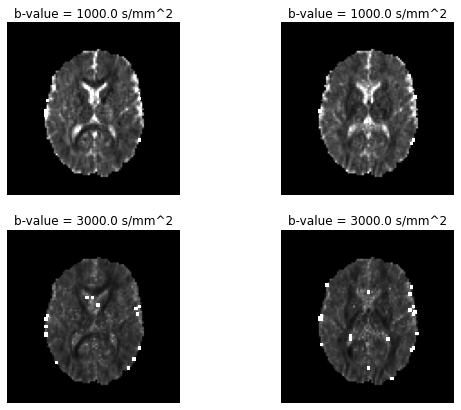

In [16]:
import numpy as np

Dapp = np.empty(data.shape)
for vi in range(0, gtab.bvals.size):
    S = data[..., vi] 
    b = gtab.bvals[vi]

    Dapp_i = - np.log(S / S0) / b
    Dapp_i[mask_bet==0] = 0   
    Dapp[..., vi] = Dapp_i

# Plot middle slice data
plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 153]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[153]))

plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 157]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[157]))

plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 483]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[483]))

plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 487]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[487]))

plt.show()


# Diffusion Tensor Imaging

The information captured by dMRI is multi-dimensional. Diffusion tensor imaging (DTI), a pioneering dMRI technique, was proposed to quantify diffusion anisotropy ([Basser et al. 1994](https://pubmed.ncbi.nlm.nih.gov/8130344/)).

Instead of the constant scalar ADC, DTI represents diffusion at each voxel using the second order diffusion tensor:

$$\mathbf{D} = \begin{bmatrix} D_{xx} & D_{xy} & D_{xz} \\ D_{yx} & D_{yy} & D_{yz} \\ D_{zx} & D_{zy} & D_{zz} \end{bmatrix} $$

This tensor can be geometrically represented by an ellipsoid, and provides valuable information on diffusion anisotropy. As it is symmetric, only 6 free parameters ($D_{xx}$, $D_{yy}$, $D_{zz}$, $D_{xy}$, $D_{xz}$, $D_{yz}$) need to be estimated when using this signal model:

$$S ( \mathbf{n}, b) = S_0 exp(-b \mathbf{n}^T \mathbf{D} \mathbf{n})$$ 

where $\mathbf{n}$ is the gradient direction.

Let's see how to apply the DTI model within Dipy [dipy.org](https://dipy.org/).

In [17]:
import dipy.reconst.dti as dti

### Load and read a sample dMRI dataset

For this example, let's load a dMRI dataset that was acquired at the Stanford University.

In [18]:
from dipy.data import get_fnames

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')

Next, we read the downloaded dataset.

In [19]:
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs

data, affine = load_nifti(hardi_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)

Let's now extract the corresponding GradientTable object according to the loaded b-values and b-vectors.

In [20]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

Let's print the b-values and b-vectors of this dataset

In [21]:
print("b-value = {} s/mm^2".format(gtab.bvals))
print("b-vectors = {} ".format(gtab.bvecs))

b-value = [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000.] s/mm^2
b-vector

From the information saved in bvals and bvecs, one can note that this dataset was acquired based on a single non-zero b-value along different diffusion gradient direction. This type of single non-zero b-value acquisition are typically refered to as single-shell acquisitions.

### Generate a brain mask

To avoid computation on the background of the image, we generate a brain mask using DIPY's mask module:

In [22]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(0, 9),
                             numpass=1, dilate=5)

### DTI reconstruction

Now that we have prepared the datasets we can go forward with the voxel reconstruction. In Dipy voxel reconstruction for all available dMRI techniques consist on two main steps:

1) a given dMRI model is instantiated according to the data acquistion parameters. For the case of DTI, we instantiate the Tensor model in the following way:

In [23]:
dti_model = dti.TensorModel(gtab)

2) after instantiating the model according to the data acquisition parameters, data fitting is very simple - you just need to call the  fit method of the TensorModel in the following way:

In [45]:
# let's apply it only to the two middle slices to save time
ax_slice = maskdata.shape[2] // 2;

dti_fit = dti_model.fit(maskdata[:, :, ax_slice:ax_slice+1, :])

The fit method creates a TensorFit object which contains the fitting parameters and standard diffusion DTI metrics as object attributes. For instance, the mean diffusivity (MD), axial diffusivity (AD), the radial diffusivity (RD), and Fractional Anisotropy (FA) can be retrieved in the following way:

In [46]:
MD = dti_fit.md
AD = dti_fit.ad
RD = dti_fit.rd
FA = dti_fit.fa

Below we plot the MD, AD, RD and FA maps for an axial slice using matplotlib:

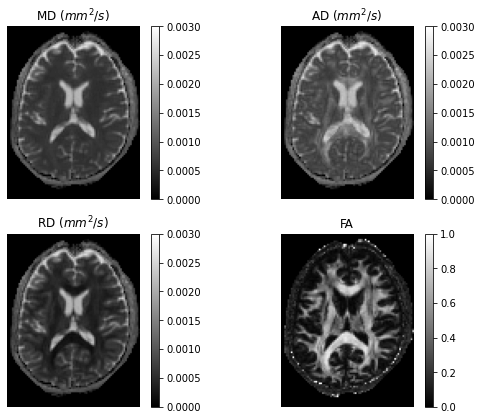

In [47]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(np.rot90(MD[..., 0]), cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("MD $(mm^2/s)$")

plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(np.rot90(AD[..., 0]), cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("AD $(mm^2/s)$")

plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(np.rot90(RD[..., 0]), cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("RD $(mm^2/s)$")

plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(np.rot90(FA[..., 0]), cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title("FA")

plt.show()

Dipy can also be used to produce a colour coded FA maps. In addition of indicating the anisotropy degree by the colour level intensity, these maps provide the information of the main direction of the diffusion tensor according to the following colour coding standard:

1) red indicates that diffusion is higher on right-left directions

2) green indicates that diffusion is higher on anterior-posterior directions

3) blue indicates that diffusion is higher on inferior-superior directions

The information about the main direction of the diffusion tensor can be retrieved from the diffusion tensor eigenvectors which is saved in "dti_fit" attribute "evecs". The colour coded FA map is produced in the following way:

Text(0.5, 1.0, 'Color coded FA')

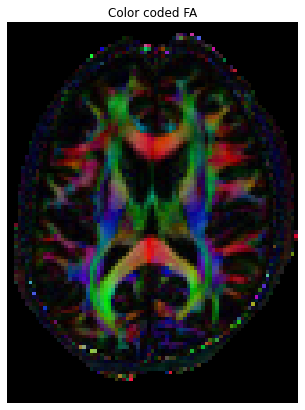

In [59]:
from dipy.reconst.dti import color_fa
import numpy as np

FA = np.clip(FA, 0, 1)  # Just to ensure that FA values are between 0 and 1
colored_FA = color_fa(FA, dti_fit.evecs)

plt.figure(figsize=(9, 7))
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(np.rot90(colored_FA[:,:, 0]))
plt.title("Color coded FA")

### Saving data

Now that you processed the standard DTI metrics, you can saved them as NIFTI files using Dipy's save_nifti function. Here, we choose to save the DTI metrics in float32.

In [ ]:
from dipy.io.image import save_nifti
import numpy as np

save_nifti('tensor_md.nii.gz', MD.astype(np.float32), affine)
save_nifti('tensor_ad.nii.gz', AD.astype(np.float32), affine)
save_nifti('tensor_rd.nii.gz', RD.astype(np.float32), affine)
save_nifti('tensor_fa.nii.gz', FA.astype(np.float32), affine)

### Plotting the Ellipsoids (Optional)

If you have fury installed, you can use Dipy to visuallize the DTI's diffusion tensor ellipsoids.

1) For visualization proposes, we will plot the ellipsoids on the following smaller rectangular area of the axial slice. This zoomed area is shown below.

Text(0.5, 1.0, 'Color coded FA')

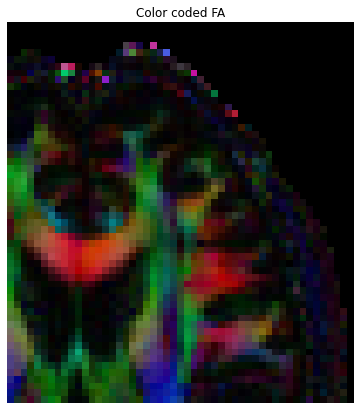

In [60]:
import numpy as np

plt.figure(figsize=(9, 7))
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(np.rot90(colored_FA[30:, 50:, 0]))
plt.title("Color coded FA")

2) Below is the code for visuallizing the DTI's diffusion tensor ellipsoids.

In [64]:
from dipy.data import get_sphere
sphere = get_sphere('repulsion724')

from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = True

scene = window.Scene()

evals = dti_fit.evals[30:, 50:, ...]
evecs = dti_fit.evecs[30:, 50:, ...]

cfa = colored_FA[30:, 50:, ...]
cfa /= cfa.max()

scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere, scale=0.7))

print('Saving illustration as tensor_ellipsoids.png')
window.record(scene, n_frames=1, out_path='img/tensor_ellipsoids.png',
              size=(600, 600))
if interactive:
    window.show(scene)

Saving illustration as tensor_ellipsoids.png
